# <stan style = "color : cyan "> Código  </stan>

In [ ]:
import json
from enum import Enum
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import savemat
import numpy as np
from shapely import Polygon, Point


class InputError(Exception):
    pass


class LoadingError(Exception):
    pass


class OutOfBounds(Exception):
    pass


class MissingParameterError(Exception):
    pass


class ObjectCreationError(Exception):
    pass


class TipoElectrodo(Enum):
    punto = 'punto'
    circulo = 'circulo'
    poligono = 'poligono'


class FormaDePloteo(Enum):
    fibras_sin_diametro = 'fibras_sin_diametro'
    fibras_con_diametro = 'fibras_con_diametro'


class PoblacionNervio(Enum):
    uniforme_con_superposicion = 'uniforme_con_superposicion'
    uniforme_sin_superposicion = 'uniforme_sin_superposicion'
    manual = 'manual'
    desde_archivo = 'desde_archivo'


class VariacionNodos(Enum):
    uniforme = 'uniforme'
    normal = 'normal'


class TipoEstimulo(Enum):
    potencial_de_accion = 'potencial_de_accion'
    cuadrado = 'cuadrado'
    manual = 'manual'
    desde_archivo = 'desde_archivo'


class TipoFibra(Enum):
    puntual = 'puntual'
    no_puntual = 'no_puntual'


def distancia_entre_puntos(x1, y1, x2, y2):
    """Función que mide la distancia entre dos puntos.

    Args:
        x1 (float): Coordenada x del primer punto. 
        y1 (float): Coordenada y del primer punto.
        x2 (float): Coordenada x del segundo punto.
        y2 (float): Coordenada y del segundo punto.

    Returns:
        float: La función devuelve la distancia entre los dos puntos.
    """
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)


def distancia_entre_circulos(x1, y1, radio1, x2, y2, radio2):
    """Método que devuelve la distancia entre dos círculos.

    Args:
        x1 (float): Coordenada x del centro del primer círculo.
        y1 (float): Coordenada y del centro del primer círculo.
        radio1 (float): Radio del primer círculo.
        x2 (float): Coordenada x del centro del segundo círculo.
        y2 (float): Coordenada y del centro del segundo círculo.
        radio2 (float): Radio del segundo círculo.

    Returns:
        float: Devuelve el cálculo de la distancia entre los dos círculos.
    """
    return (distancia_entre_puntos(x1=x1, y1=y1, x2=x2, y2=y2)) - radio1 - radio2


def is_inside_circencirc(r1, x1, y1, r0, x0, y0):
    """Función con la que se evalúa si un primer círculo (x1,y1,r1) se encuentra dentro de un segundo círculo (x0,y0,r0).

    Args:
        r1 (float): Radio del primer círculo.
        x1 (float): Coordenada x del centro del primer círculo.
        y1 (float): Coordenada y del centro del primer círculo.
        r0 (float): Radio del círculo al que se le evalúa si contiene al primer círculo.
        x0 (float, optional): Coordenada x del centro del círculo al que se le evalúa si contiene al primer círculo. Por defecto es 0.
        y0 (float, optional): Coordenada y del centro del círculo al que se le evalúa si contiene al primer círculo. Por defecto es 0.

    Returns:
        bool: Devuelve True o False de acuerdo a si el primer círculo está contenido dentro del segundo o no.
    """
    return r0 >= r1 + distancia_entre_puntos(x1=x1, y1=y1, x2=x0, y2=y0)


def funcion_trapecio(x, z, d, a):
    """Función trapecio. Devuelve el valor de la función trapecio para un dado x.

    Args:
        x (float): Valor en el cual se evaluará la función trapecio.
        z (float): Centro simétrico del trapecio.
        d (float): La mitad del valor del largo inferior del trapecio.
        a (float): La mitad del largo superior del trapecio.

    Returns:
        float: Devuelve el valor de la función evaluado en un dado x.
    """
    if (x > z - d - a and x < z - a):
        return (x - z + d + a) / d
    if (x > z + a and x < z + a + d):
        return (z + a + d - x) / d
    if (x >= z - a and x <= z + a):
        return 1
    return 0


def funcion_gaussiana(x, z, d, a):
    """Función exponencial con caída como una función gaussiana. 

    Args:
        x (float): Valor en el cual se evaluará la función.
        z (float): mu, esperanza de la función gaussiana.
        d (float): Valor hasta el cual se quiere lograr la caída de la función.
        a (float): Valor hasta el cual se quiere mantener la función igual a 1.

    Returns:
        float: Devuelve el valor de la función evaluado en un dado x.
    """
    if (x > z - d - a and x < z - a):
        exponente = -(x - (z - a))**2 / (2 * (d / 3)**2)
        return np.exp(exponente)
    if (x > z + a and x < z + a + d):
        exponente = -(x - (z + a))**2 / (2 * (d / 3)**2)
        return np.exp(exponente)
    if (x >= z - a and x <= z + a):
        return 1
    return 0


def funcion_constante(x, z, d, a, v):
    """Función que devuelve un valor constante en un cierto rango.

    Args:
        x (float): Valor en el cual se evaluará la función.
        z (float): Centro del intervalo.
        d (float): Valor del ancho del intervalo, hacia izquierda o derecha.
        a (float): Extensión para el ancho del intervalo, hacia izquierda o derecha.
        valor (float): El valor de la función cuando no es cero.

    Returns:
        float: Devuelve el valor de la función evaluado en un dado x.
    """
    if x >= z - d - a and x <= z + d + a:
        return v

    return 0


def insertar_estimulo(estimulo, posicion, fm, tiempo_registro, velocidad, peso):
    """Función que desplaza un numpy array dada una posición de inicio.

    Args:
        estimulo (numpy.ndarray): Señal que es desplazada.
        posicion (float): Posición hasta la que se desplaza el inicio del estímulo. En micrometros.
        fm (float): Frecuencia de muestreo de la señal. En Hz.
        tiempo_registro (float): Tiempo total en el que se hará el registro. En segundos.
        velocidad (float): Velocidad a la cual se desplaza la señal. En m/s.
        peso (float): Factor por el cual se multiplica la señal.

    Returns:
        numpy.ndarray: Devuelve el estímulo desplazado, en el tiempo de registro.
    """
    total_muestras = int(tiempo_registro * fm)
    muestras_estimulo = len(estimulo)
    vector = np.zeros(total_muestras)
    inicio = int((posicion * fm) / (velocidad * 1000000))  #retardo

    if inicio < total_muestras and peso != 0:
        if muestras_estimulo > (total_muestras - inicio):
            muestras_estimulo = total_muestras - inicio
        vector[inicio:inicio + muestras_estimulo] = estimulo[0:muestras_estimulo] * peso
        return vector

    return None


def array_to_multiarray(array, estimulo, fm, tiempo_registro, velocidad, peso):
    """Función que, dado un array con posiciones, crea un array de arrays, con estímulos desplazados para cada posición.

    Args:
        array (numpy.ndarray): Array que contiene las posiciones con las cuales se hará el desplazamiento del estímulo.
        estimulo (numpy.ndarray): Señal que es desplazada.
        fm (float): Frecuencia de muestreo. En Hz.
        tiempo_registro (float): Tiempo total en el que se hará el registro. En segundos.
        velocidad (float): Velocidad a la cual se desplaza la señal. En m/s.
        peso (float): Factor por el cual se multiplica la señal. 

    Returns:
        numpy.ndarray: Devuelve el array de arrays con los estímulos desplazados.
    """
    total_muestras = int(tiempo_registro * fm)
    multiarray = np.zeros((len(array), total_muestras))
    for i, posicion in enumerate(array):
        vector = insertar_estimulo(estimulo=estimulo,
                                   posicion=posicion,
                                   fm=fm,
                                   tiempo_registro=tiempo_registro,
                                   velocidad=velocidad,
                                   peso=peso[i])
        if vector is not None:
            multiarray[i] = vector
    return multiarray


class Nervio:
    """Nervio.
    """

    def __init__(self, diametro, longitud, conductividad_transversal=None, porcentaje_cobertura=None):
        """Método constructor de la clase Nervio.

        Args:
            diametro (int): Diametro del nervio en micrómetros.
            longitud (int): Longitud del nervio en micrometros.
            conductividad_transversal (float, optional): Conductividad transversal del nervio. Por defecto None.
            porcentaje_cobertura (float, optional): Porcentaje del nervio al cual llega el electrodo. Por defecto None.

        Raises:
            InputError: Se levanta este error si no se ingresa un valor de conductividad_transversal o de pocentaje_cobertura, dado que uno de los dos es necesario para realizar cálculos posteriores.
        """
        self.radio = diametro / 2
        self.longitud_nervio = longitud
        self.conductividad_transversal = conductividad_transversal
        self.porcentaje_cobertura = porcentaje_cobertura
        self.fibras = []
        self.cantidad_fibras = 0
        self.limite_lateral_izquierdo = -self.radio
        self.limite_lateral_derecho = self.radio
        self.limite_superior = self.radio
        self.limite_inferior = -self.radio
        self.centro_nervio_x = 0
        self.centro_nervio_y = 0
        self.informacion_nodos = []
        self.metodo_poblacion = None
        self.distancia_nodos_promedio = None

        if self.conductividad_transversal is None and self.porcentaje_cobertura is None:
            raise InputError(
                "Se debe ingresar ya sea un valor de conductividad transversal o un porcentaje de cobertura.")

    def info_nervio(self):
        """Método que devuelve un diccionario con información del nervio.

        Returns:
            dict: Diccionario con información del nervio.
        """
        return {
            "diametro": 2 * self.radio,
            "cantidad_fibras": self.cantidad_fibras,
            "longitud": self.longitud_nervio,
            "posicion_centro_nervio": [self.centro_nervio_x, self.centro_nervio_y],
            "conductividad_transversal": self.conductividad_transversal,
            "porcentaje_de_cobertura": self.porcentaje_cobertura
        }

    def informacion_fibras(self):
        """Método para obtener una lista con la información de las fibras dentro del nervio.

        Returns:
            numpy.ndarray: Devuelve un array cuyas dos primeras columnas son las coordenadas x e y de cada fibra, y la tercera columna contiene información del diámetro de las fibras.
        """
        return np.array([fibra.obtener_info_fibra() for fibra in self.fibras])

    def poblar(self,
               num_fibras,
               diametro_fibra,
               var_diametro,
               metodo_poblacion='uniforme_con_superposicion',
               semilla=None,
               alfa=7.6,
               velocidad=None,
               **kwargs):
        """Método para poblar el nervio con las fibras nerviosas.

        Args:
            num_fibras (int): Número de fibras que contendrá el nervio.
            diametro_fibra (float): Diámetro de la fibra en micrones.
            var_diametro (int): La variación del diámetro se hace con la función normal, por lo que este es el sigma.
            metodo_poblacion (str, optional): Tipo de método de población de fibras en el nervio. Por defecto es 'uniforme'.
            semilla (int, optional): Número de la semilla. Por defecto es None.
            alfa (float, optional): Valor para calcular la velocidad de conducción de las fibras. Por defecto es 7.6. En [m/s/micrómetro]
            velocidad (float,optional): Velocidad de la fibra en [m/s].
        
        Keyword Args:
            array_fibras (numpy.ndarray): Numpy array con 4 columnas: posición x, posición y, diámetro y velocidad de cada fibra, en el método de población manual.
            ubicacion_archivo (str): String con la ubicación del archivo csv para el método de población desde_archivo. El archivo csv debe contener 4 columnas: posición x, posición y, diámetro y velocidad de cada fibra.

        Raises:
            InputError: Si el método de población ingresado no se encuentra entre las opciones disponibles.
        """
        self.metodo_poblacion = metodo_poblacion
        if metodo_poblacion == PoblacionNervio.uniforme_con_superposicion.name:
            if diametro_fibra is None:
                raise InputError('Se debe ingresar un diámetro de fibra.')
            self.uniforme_con_superposicion(num_fibras=num_fibras,
                                            diametro_fibra=diametro_fibra,
                                            var_diametro=var_diametro,
                                            semilla=semilla,
                                            alfa=alfa,
                                            velocidad=velocidad)
        elif metodo_poblacion == PoblacionNervio.uniforme_sin_superposicion.name:
            if diametro_fibra is None:
                raise InputError('Se debe ingresar un diámetro de fibra.')
            self.uniforme_sin_suporsicion(num_fibras=num_fibras,
                                          diametro_fibra=diametro_fibra,
                                          var_diametro=var_diametro,
                                          semilla=semilla,
                                          alfa=alfa,
                                          velocidad=velocidad)
        elif metodo_poblacion == PoblacionNervio.manual.name:
            self.manual(array_fibras=kwargs.get('array_fibras', None))
        elif metodo_poblacion == PoblacionNervio.desde_archivo.name:
            self.desde_archivo(ubicacion_archivo=kwargs.get('ubicacion_archivo', None))
        else:
            raise InputError('El método de población ingresado no es correcto.')

    def uniforme_con_superposicion(self, num_fibras, diametro_fibra, var_diametro, semilla, alfa, velocidad):
        """Función para poblar el nervio con distribución uniforme, con superposición de las fibras.

        Args:
            num_fibras (int): Número de fibras que contendrá el nervio.
            diametro_fibra (float): Diámetro de la fibra en micrones.
            var_diametro (int): La variación del diámetro se hace con la función normal, por lo que este es el sigma.
            semilla (int): Número de la semilla.
            alfa (float): Valor para calcular la velocidad de conducción de las fibras.
            velocidad (float): Velocidad de la fibra en [m/s].
        """
        #Tiene centro en (0,0), implementar el traslado
        np.random.seed(semilla)
        longitud = np.random.uniform(0, self.radio**2, size=num_fibras)
        angulo = np.pi * np.random.uniform(0, 2, size=num_fibras)
        diam = []
        while len(diam) < num_fibras:
            diametro = np.random.normal(diametro_fibra, var_diametro)
            if diametro > 0:
                diam.append(diametro)
        x = np.sqrt(longitud) * np.cos(angulo)
        y = np.sqrt(longitud) * np.sin(angulo)
        matriz = np.column_stack((x, y, np.array(diam)))
        self.fibras = [
            Fibra(x=x, y=y, diametro=diam, velocidad=alfa *
                  diam) if velocidad is None else Fibra(x=x, y=y, diametro=diam, velocidad=velocidad)
            for x, y, diam in matriz
        ]
        self.cantidad_fibras = num_fibras

    def uniforme_sin_suporsicion(self, num_fibras, diametro_fibra, var_diametro, semilla, alfa, velocidad):
        """Función para poblar el nervio con distribución uniforme, sin superposición de las fibras.

        Args:
            num_fibras (int): Número de fibras que contendrá el nervio.
            diametro_fibra (float): Diámetro de la fibra en micrones.
            var_diametro (int): La variación del diámetro se hace con la función normal, por lo que este es el sigma.
            semilla (int): Número de la semilla.
            alfa (float): Valor para calcular la velocidad de conducción de las fibras.
            velocidad (float): Velocidad de la fibra en [m/s].
        """
        np.random.seed(semilla)
        lista = []

        while len(lista) < num_fibras:
            choque = False
            length = np.random.uniform(0, self.radio**2)
            angle = np.pi * np.random.uniform(0, 2)
            diam = np.random.normal(diametro_fibra, var_diametro)
            while diam <= 0:
                diam = np.random.normal(diametro_fibra, var_diametro)
            x = np.sqrt(length) * np.cos(angle)
            y = np.sqrt(length) * np.sin(angle)

            for a, b, c in lista:
                if distancia_entre_circulos(x, y, diam / 2, a, b, c / 2) < 0:
                    choque = True
            if choque is False and is_inside_circencirc(diam / 2, x, y, self.radio, self.centro_nervio_x,
                                                        self.centro_nervio_y):
                lista.append([x, y, diam])

        self.fibras = [
            Fibra(x=x, y=y, diametro=diam, velocidad=alfa *
                  diam) if velocidad is None else Fibra(x=x, y=y, diametro=diam, velocidad=velocidad)
            for x, y, diam in lista
        ]
        self.cantidad_fibras = num_fibras

    def manual(self, array_fibras):
        """Función para poblar el nervio de forma manual, a partir de un array con la posición de las fibras, y sus diámetros.

        Args:
            array_fibras (numpy.ndarray): Array con la posición y diámetros de las fibras, si lo tuviera.
            
        Raises:
            ValueError: Valor que se levanta cuando se encuentra que en el array ingresado no se encuentran todos los parámetros necesarios.
            OutOfBounds: Error que se levanta si se encuentra que alguna de las fibras ingresadas supera los límites del nervio.
        """
        try:
            f = [
                Fibra(x, y, d, v)
                for x, y, d, v in array_fibras
                if is_inside_circencirc(d / 2, x, y, self.radio, self.centro_nervio_x, self.centro_nervio_y)
            ]
        except ValueError as exc:
            raise ValueError(
                'Se necesitan los datos de ubicación de fibras en eje x e y, diámetros y velocidades para este método.'
            ) from exc

        if len(f) != len(array_fibras):
            raise OutOfBounds("Se encontró por lo menos una fibra fuera de los límites del nervio.")

        self.fibras = f
        self.cantidad_fibras = len(array_fibras)

    def desde_archivo(self, ubicacion_archivo):
        """Función para poblar un nervio, a partir de un archivo csv.

        Args:
            ubicacion_archivo (str): String con la ubicación del archivo csv.
            
        Raises:
            LoadingError: Error que se levanta cuando no se puede cargar el archivo.
            ValueError: Error que se levanta cuando se detecta que algún caracter ingresado en el archivo no es numérico.
        """
        try:
            fibras = np.genfromtxt(ubicacion_archivo, delimiter=',')
        except Exception as e:
            raise LoadingError('Fallo en carga de archivo.') from e

        if not np.isnan(sum(fibras)).any() and np.issubdtype(fibras.dtype, np.number):
            self.manual(array_fibras=fibras)
        else:
            raise ValueError("La lista contiene caracteres que no son números.")

    def ploteo_fibras_puntos(self, borde_nervio='blue', relleno_nervio='None', color_fibras='red'):
        """Método para graficar una vista transversal del nervio. Las fibras se muestran como puntos (sin diámetro real).

        Args:
            borde_nervio (str, optional): Color del borde del nervio. Por defecto es azul ('blue').
            relleno_nervio (str, optional): Color del relleno del nervio. Por defecto no tiene color ('None').
            color_fibras (str, optional): Color de las fibras, graficadas como puntos. Escribirlo según formato aceptable por Matplotlib. Por defecto es rojo ('r').
        """

        #Ploteo de las fibras
        matriz = self.informacion_fibras()
        plt.plot(matriz[:, 0], matriz[:, 1], label='Fibras', color=color_fibras, marker='.', linestyle='None')

        #Ploteo del nervio
        plt.gca().add_patch(
            plt.Circle((0, 0), self.radio, edgecolor=borde_nervio, facecolor=relleno_nervio, label='Nervio'))

    def ploteo_fibras_circulos(self,
                               borde_nervio='blue',
                               relleno_nervio='None',
                               borde_fibras='red',
                               relleno_fibras='None'):
        """Método para graficar una vista transversal del nervio. Las fibras se muestran como círculos, con su respectivo diámetro.

        Args:
            borde_nervio (str, optional): Color del borde del nervio. Por defecto es azul ('blue').
            relleno_nervio (str, optional): Color del relleno del nervio. Por defecto no tiene color ('None').
            borde_fibras (str, optional): Color del borde de las fibras. Por defecto es rojo ('red').
            relleno_fibras (str, optional): Color del relleno de las fibras. Por defecto no tiene color ('None').

        Raises:
            InputError: Cuando se encuentra por lo menos una fibra con diámetro igual a 0.
        """
        matriz = self.informacion_fibras()
        if matriz[:, 2].any() == 0:
            raise InputError("Por lo menos una fibra tiene diámetro igual a 0.")

        #Ploteo de las fibras
        for i in range(len(matriz)):
            circle = plt.Circle((matriz[i, 0], matriz[i, 1]),
                                matriz[i, 2],
                                edgecolor=borde_fibras,
                                facecolor=relleno_fibras,
                                label="Fibras" if i == 0 else "")
            plt.gca().add_patch(circle)

        #Ploteo del nervio
        plt.gca().add_patch(
            plt.Circle((0, 0), self.radio, edgecolor=borde_nervio, facecolor=relleno_nervio, label='Nervio'))

    def agregar_nodos(self, distancia_nodos, variacion_nodos, desplazamiento, distribucion_variacion='uniforme'):
        """Método que permite agregar nodos a las fibras. 

        Args:
            distancia_nodos (float): Distancia entre nodos en las fibras en micrómetros.
            variacion (float): Variación de la distancia entre nodos en micrómetros.
            desplazamiento (float): Desplazamiento de los nodos en micrómetros. 
            distribucion_variacion (str, optional): Distribución de la variación de la distancia entre nodos. Se espera un valor correspondiente a alguna de las opciones de VariacionNodos. Por defecto es 'uniforme'.
        """
        self.distancia_nodos_promedio = distancia_nodos
        self.informacion_nodos = [
            f.ubicar_nodos(distancia_nodos=distancia_nodos,
                           variacion=variacion_nodos,
                           desplazamiento=np.random.uniform(-desplazamiento, desplazamiento),
                           distribucion_variacion=distribucion_variacion,
                           longitud_fibra=self.longitud_nervio) for f in self.fibras
        ]


class Fibra:
    """Fibra.
    """

    def __init__(self, x, y, diametro, velocidad):
        """Método constructor de la clase Fibra.

        Args:
            x (float): Posición x del centro de la fibra. En micrómetros.
            y (float): Posición y del centro de la fibra. En micrómetros.
            diametro (float): Diámetro de la fibra. En micrómetros.
            velocidad (float): Velocidad de la fibra en [m/s].
        """
        self.x = x
        self.y = y
        self.radio = diametro / 2
        self.ubicacion_nodos = []
        self.velocidad = velocidad

    def info_fibra(self, numero, pesos, electrodo):
        """Método que proporciona un diccionario con información sobre la fibra.

        Args:
            numero (int): Número de fibra.
            pesos (np.ndarray): Array con los pesos de los nodos de las fibras.
            electrodo (Electrodo): Objeto de la clase Electrodo.

        Returns:
            dict: Diccionario con información de la fibra y sus nodos.
        """
        datos_fibras = {
            "fibra": numero,
            "posicion_transversal_fibra": [self.x, self.y],
            "diametro": 2 * self.radio,
            "velocidad": self.velocidad,
            "nodos": [{
                "ubicacion": ubicacion,
                "peso": pesos[i]
            } for i, ubicacion in enumerate(self.ubicacion_nodos)],
            "SFAP": electrodo.sfap[numero].tolist()
        }
        return datos_fibras

    def obtener_info_fibra(self):
        """Método que permite obtener información sobre la fibra, en forma de lista.

        Returns:
            list: Información sobre la fibra (posición en eje x, posición en eje y, radio de la fibra, velocidad de conducción de la fibra).
        """
        return [self.x, self.y, self.radio, self.velocidad]

    def ubicar_nodos(self, longitud_fibra, distancia_nodos, variacion, desplazamiento, distribucion_variacion):
        """Método para agregar nodos a una fibra.
        Args:
            longitud_fibra (float): Longitud de la fibra en micrómetros.
            distancia_nodos (float): Distancia entre nodos en las fibras en micrómetros.
            variacion (float): Variación de la distancia entre nodos en micrómetros.
            desplazamiento (float): Desplazamiento de los nodos en micrómetros. 
            distribucion_variacion (str): Distribución de la variación de la distancia entre nodos. Se espera un valor correspondiente a alguna de las opciones de VariacionNodos.

        Returns:
            numpy.ndarray: Devuelve un array con la ubicación de los nodos de la fibra.
        """
        #arr = np.arange(-longitud_fibra/2,longitud_fibra*1.5 +1,distancia_nodos)
        arr = np.arange(-longitud_fibra / 2, longitud_fibra * 1.5, distancia_nodos)
        if distribucion_variacion == VariacionNodos.uniforme.name:
            var = np.random.uniform(-variacion / 2, variacion / 2, len(arr)) + desplazamiento
        elif distribucion_variacion == VariacionNodos.normal.name:
            var = np.random.normal(0, variacion, len(arr)) + desplazamiento

        ubicacion = arr + var
        ubicacion = ubicacion[(ubicacion > 0) & (ubicacion < longitud_fibra)]
        self.ubicacion_nodos = ubicacion
        return ubicacion


class Electrodo:
    """Electrodo.
    """

    def __init__(self, tipo, zona_influencia, grosor=0, **kwargs):
        """Método constructor de la clase Electrodo.

        Args:
            tipo (str): Tipo de electrodo. Puede ser los enumerados en el Enum TipoElectrodo.
            zona_influencia (float): Es la zona a cualquiera de los lados a la cual tiene alcance el electrodo. En micrometros.
            grosor (int, optional): Grosor del electrodo en micrometros. Por defecto es 0 micrometros. 
            **kwargs: Argumentos adicionales con nombre.
        
        Keyword Args:
            pos_x (float): Posición del electrodo en el eje x. En micrómetros.
            pos_y (float): Posición del electrodo en el eje y. En micrómetros.
            pos_z (float): Posición del electrodo en el eje z. En micrómetros.
            radio (float): Radio del electrodo tipo Circulo. En micrómetros.
            lista_coordenadas (list): Coordenadas en micrometros del electrodo tipo Poligono.

        Raises:
            InputError: Si el tipo de electrodo ingresado no es correcto.
            MissingParameterError: Si no se ingresan los parámetros necesarios para cada tipo de electrodo.
        """

        self.tipo = tipo
        self.dist_al_electrodo = []
        self.wmax = []
        self.wlong = []
        self.pesos = []
        self.grosor = grosor
        self.zona_influencia = zona_influencia  #es la zona a izquierda o derecha que abarca el electrodo, no la zona completa
        self.valor = kwargs.get('valor', None)
        self.sfap = None
        self.cap = None

        if self.tipo == TipoElectrodo.punto.name:
            self.x = kwargs.get('pos_x')
            self.y = kwargs.get('pos_y')
            self.z = kwargs.get('pos_z')
            self.shape = Point(self.x, self.y)
            if self.x is None or self.y is None or self.z is None:
                raise MissingParameterError(
                    'Los parámetros pos_x, pos_y, pos_z son necesarios para electrodo tipo Punto.')
        elif self.tipo == TipoElectrodo.circulo.name:
            self.x = kwargs.get('pos_x')
            self.y = kwargs.get('pos_y')
            self.z = kwargs.get('pos_z')
            self.radio = kwargs.get('radio')
            self.shape = Point(self.x, self.y).buffer(self.radio)
            if self.x is None or self.y is None or self.radio is None or self.z is None:
                raise MissingParameterError(
                    'Los parámetros pos_x, pos_y, pos_z, radio son necesarios para el electrodo tipo Círculo.')
        elif self.tipo == TipoElectrodo.poligono.name:
            self.z = kwargs.get('pos_z')
            self.coordenadas = kwargs.get('lista_coordenadas')
            self.shape = Polygon(self.coordenadas)
            if self.z is None or self.coordenadas is None:
                raise MissingParameterError(
                    "Los parámetros pos_z y lista_coordenadas son necesarios para el electrodo tipo Polígono.")
        else:
            raise InputError('El tipo de electrodo ingresado no es correcto.')

    def info_electrodo(self, idx):
        """Método que genera un diccionario con información del electrodo.

        Args:
            idx (int): Ubicación del electrodo en la lista de electrodos de la clase Entorno.

        Returns:
            dict: Devuelve un diccionario con información del electrodo.
        """
        return {
            "electrodo_numero": idx,
            "tipo": self.tipo,
            "posicion_transversal_electrodo": [self.x, self.y],
            "posicion_longitudinal_electrodo": self.z,
            "espesor": self.grosor,
            "zona_de_influencia": self.zona_influencia,
        }

    def ploteo_electrodo(self, idx):
        """Método que dibuja al electrodo en el espacio.

        Args:
            idx (int): Ubicación del electrodo en la lista de electrodos de la clase Entorno.
        """
        if self.tipo == TipoElectrodo.punto.name:
            x, y = self.shape.x, self.shape.y
            plt.plot(x, y, 'o', label=f"Electrodo {idx}")
        elif self.tipo in (TipoElectrodo.circulo.name, TipoElectrodo.poligono.name):
            x, y = self.shape.exterior.xy
            plt.plot(x, y, label=f"Electrodo {idx}")

    def calcular_distancias(self, lista_fibras, tipo_fibra):
        """Método para calcular distancias desde el electrodo a las fibras.

        Args:
            lista_fibras (list): Lista de objetos Fibra.
            tipo_fibra (str): Consideracion de la fibra para calcular distancias. Puede ser 'puntual' o 'no_puntual'.
        """
        if tipo_fibra == TipoFibra.puntual.name:
            self.dist_al_electrodo = np.array([self.shape.distance(Point(f.x, f.y)) for f in lista_fibras])
        elif tipo_fibra == TipoFibra.no_puntual.name:
            self.dist_al_electrodo = np.array(
                [self.shape.distance(Point(f.x, f.y).buffer(f.radio)) for f in lista_fibras])
        else:
            raise TypeError("El tipo de fibra ingresado no es correcto.")

    def calcular_wmax(self, nervio):
        """Método para calcular los pesos transversales (Wmax) para cada fibra del nervio.

        Args:
            nervio (Nervio): El nervio que contiene las fibras a las cuales se les calculará el Wmax.
        """
        if nervio.conductividad_transversal is not None:
            cond_transversal = nervio.conductividad_transversal * max(self.dist_al_electrodo)
        else:
            cond_transversal = nervio.porcentaje_cobertura / 100 * max(self.dist_al_electrodo)

        self.wmax = np.array(
            [1 - (x / cond_transversal) if (x >= 0 and x < cond_transversal) else 0 for x in self.dist_al_electrodo])

    def calcular_wlong(self, funcion, matriz_nodos):
        """Método para calcular los pesos longitudinales para cada nodo de cada fibra.

        Args:
            funcion (Callable): Función con la cual se calcularán los pesos longitudinales (Wlong).
            matriz_nodos (list): Lista con la información de la ubicación de nodos de cada fibra.
        """
        a = self.grosor / 2
        d = self.zona_influencia
        v = self.valor
        if funcion == funcion_constante:
            wlong = np.array(
                [np.array([funcion_constante(x=x, z=self.z, a=a, d=d, v=v) for x in lista]) for lista in matriz_nodos])
        else:
            wlong = np.array([np.array([funcion(x=x, z=self.z, a=a, d=d) for x in lista]) for lista in matriz_nodos],
                             dtype=object)
        self.wlong = wlong

    def calcular_pesos(self, nervio, funcion, matriz_nodos):
        """Método que calcula los pesos en cada nodo para cada fibra del nervio.

        Args:
            nervio (Nervio): Objeto de la clase Nervio. Nervio que contiene las fibras.
            funcion (Callable): Función con la cual se calcularán los pesos longitudinales (Wlong).
            matriz_nodos (list): Lista con la ubicación de los nodos de cada fibra.
        """
        self.calcular_wmax(nervio)
        self.calcular_wlong(funcion, matriz_nodos)
        self.pesos = np.array(
            [np.array([wmax * wlong for wlong in lista_wlong]) for wmax, lista_wlong in zip(self.wmax, self.wlong)],
            dtype=object)

    def sfap_funcion(self, frec_muestreo, velocidad_fibras, tiempo_registro, estimulo, ubicacion_nodos, num_fibras):
        """Método que calcula los Potenciales de Acción de Fibra Unica para cada fibra que se encuentra en el Nervio.

        Args:
            frec_muestreo (float): Frecuencia de muestreo. En Hz.
            velocidad_fibras (float): Velocidad de conducción de una fibra. En m/s.
            tiempo_registro (float): Tiempo en el que se realiza el registro. En segundos.
            estimulo (numpy.ndarray): Array con los estímulos por fibra. 
            ubicacion_nodos (numpy.ndarray): Array con la ubicación de los nodos en todas las fibras.
            num_fibras (int): Cantidad de fibras en el nervio.
        """
        total_muestras = int(tiempo_registro * frec_muestreo)
        sfap_matriz = np.zeros((len(ubicacion_nodos), total_muestras))
        for i, posiciones in enumerate(ubicacion_nodos):
            estimulo_por_nodo = array_to_multiarray(array=posiciones,
                                                    estimulo=estimulo[i],
                                                    fm=frec_muestreo,
                                                    tiempo_registro=tiempo_registro,
                                                    velocidad=velocidad_fibras[i],
                                                    peso=self.pesos[i])
            sfap = np.sum(estimulo_por_nodo, axis=0)
            sfap_matriz[i] = sfap
        self.sfap = sfap_matriz / num_fibras

    def cap_funcion(self):
        """Función que calcula el Potencial de Acción Compuesto captado por el electrodo.
        """
        self.cap = np.sum(self.sfap, axis=0)


class Estimulador:
    """Encargado de generar el impulso de entrada al Nervio.
    """

    def __init__(self, frec_muestreo, tiempo_estimulo, num_fibras):
        """Método constructor de la clase Estimulador.

        Args:
            frec_muestreo (float): Frecuencia de muestreo. En Hz.
            tiempo_estimulo (float): Tiempo total que durará el registro. En segundos.
            num_fibras (int): Número de fibras del nervio.
        """
        self.cant_muestras = int(frec_muestreo * tiempo_estimulo)
        self.frec = frec_muestreo
        self.tiempo_estimulo = tiempo_estimulo
        self.num_fibras = num_fibras
        self.estimulo = None
        self.vector_tiempo = np.arange(1 / self.frec, self.tiempo_estimulo + 1 / self.frec, 1 / self.frec)
        self.tipo_estimulo = None

    def crear_estimulo(self, tipo_estimulo, **kwargs):
        """Método para crear el estímulo que se usará con las fibras del nervio.

        Args:
            tipo_estimulo (str): Tipo de estímulo que se creará. Se detallan en el enum TipoEstimulo.
            
        Keyword Args:
            duracion(float): Tiempo en segundos que durará la señal cuadrada.
            tiempo_inicio (float): Momento en el que inicia el estímulo. En segundos.
            lista_tiempo_inicio(list): Lista con los tiempos en segundos en los cuales se quiere tener un potencial de acción.
            frec_corte(float): Frecuencia de corte del filtro Butterworth. En Hz.
            orden_filtro(int): Orden del filtro pasa bajos.
            ubicacion_archivo(str): Ubicación del archivo csv con la señal de estimulación.
            array_estimulo(numpy.ndarray): Numpy array con la señal de estimulación.

        Raises:
            InputError: Se levanta cuando se ingresa un tipo de estímulo no válido.
        """
        self.tipo_estimulo = tipo_estimulo
        if tipo_estimulo == TipoEstimulo.cuadrado.name:
            self.estimulo_cuadrado(tiempo_inicio=kwargs.get("tiempo_inicio", 0), duracion=kwargs.get('duracion', 0.0),voltaje = kwargs.get('voltaje',1))
        elif tipo_estimulo == TipoEstimulo.potencial_de_accion.name:
            self.potencial_de_accion(tiempo_inicio=kwargs.get("tiempo_inicio", 0),
                                     frec_corte=kwargs.get('frec_corte', 1000),
                                     orden_filtro=kwargs.get('orden_filtro', 2),
                                     lista_inicio=kwargs.get("lista_inicio", None))
        elif tipo_estimulo == TipoEstimulo.manual.name:
            self.estimulo_manual(array_estimulo=kwargs.get('array_estimulo', None),
                                 tiempo_inicio=kwargs.get("tiempo_inicio", 0))
        elif tipo_estimulo == TipoEstimulo.desde_archivo.name:
            self.estimulo_desde_archivo(tiempo_inicio=kwargs.get("tiempo_inicio", 0),
                                        ubicacion_archivo=kwargs.get('ubicacion_archivo', None))
        else:
            raise InputError("El tipo de impulso ingresado no es correcto.")

    def estimulo_cuadrado(self, tiempo_inicio, duracion,voltaje):
        """Método para crear un estímulo cuadrado o spike.

        Args:
            tiempo_inicio (float): Tiempo en el que se desea iniciar el estímulo. En segundos.
            duracion (float): Tiempo que durará el estímulo. Si es cero, se tendrá una spike. En segundos.
        """
        inicio = int(tiempo_inicio * self.frec)
        duracion = duracion * self.frec
        self.estimulo = np.array([
            np.array([voltaje if (j >= inicio and j <= (inicio + duracion)) else 0
                      for j in range(self.cant_muestras)])
            for i in range(self.num_fibras)
        ])

    def potencial_de_accion(self, tiempo_inicio, lista_inicio, frec_corte, orden_filtro):
        """Método para crear un potencial de acción.

        Args:
            tiempo_inicio (float): Tiempo en el que se desea iniciar el estímulo. En segundos.
            lista_tiempo_inicio (list): Lista con los tiempos (en segundos) en donde comenzará la señal.
            frec_corte (float): Frecuencia de corte del filtro pasabajos Butterworth. En Hz.
            orden_filtro (int): Orden del filtro Butterworth.
        """

        if lista_inicio is not None:
            inicio = [int(i * self.frec) for i in lista_inicio]
        else:
            inicio = int(tiempo_inicio * self.frec)

        #Señal de entrada
        x = np.zeros_like(self.vector_tiempo)
        x[inicio] = 1

        #Filtro Butter
        b, a = signal.butter(orden_filtro, frec_corte / (self.frec / 2))
        Vm = signal.lfilter(b, a, x)
        Vm = Vm / np.max(Vm)  #Vm normalizado

        self.estimulo = np.repeat([Vm], self.num_fibras, axis=0)

    def estimulo_manual(self, array_estimulo, tiempo_inicio):
        """Método para crear un estímulo de forma manual, a partir de un array con la señal.

        Args:
            array_estimulo (numpy.ndarray): Señal con la cual se estimularán las fibras del nervio.
            tiempo_inicio (float): Tiempo en el que inicia el estímulo. En segundos.
        """
        if len(array_estimulo) != self.num_fibras:
            raise InputError(
                "EL array con la señal del estímulo debe tener tantas filas como fibras haya en el nervio.")
        estim = np.zeros((len(array_estimulo), self.cant_muestras))
        inicio = int(tiempo_inicio * self.frec)
        flag = False

        if not np.isnan(sum(array_estimulo)).any() and np.issubdtype(array_estimulo.dtype, np.number):
            for i, est in enumerate(array_estimulo):
                muestras_estimulo = len(est)
                if muestras_estimulo > self.cant_muestras - inicio:
                    muestras_estimulo = self.cant_muestras - inicio
                    flag = True
                estim[i][inicio:inicio + muestras_estimulo] = array_estimulo[i][:muestras_estimulo]
        if flag is True:
            print("Se recortó por lo menos una señal de estímulo debido a su tamaño.")

        estim_normalizado = estim / np.amax(estim, axis=1, keepdims=True)
        self.estimulo = estim_normalizado

    def estimulo_desde_archivo(self, ubicacion_archivo, tiempo_inicio):
        """Método para cargar un estímulo desde un archivo csv.

        Args:
            ubicacion_archivo (str): Ubicación del archivo csv.
            tiempo_inicio (float): Tiempo en el que se iniciará el estímulo. En segundos.

        Raises:
            LoadingError: Error que se levanta cuando no se puede leer el archivo.
        """
        try:
            estimulo = np.genfromtxt(ubicacion_archivo, delimiter=',')
        except Exception as e:
            raise LoadingError('Fallo en la carga del archivo.') from e

        self.estimulo_manual(array_estimulo=estimulo, tiempo_inicio=tiempo_inicio)


class Entorno:
    """Entorno.
    """

    def __init__(self, nombre=None, tiempo_registro=None):
        """Metodo constructor de la clase Entorno.

        Args:
            nombre (str, optional): Nombre del experimento. Por defecto es None.
            tiempo_registro (float, optional): Tiempo en el cual se realiza el registro de la señal en segundos. Por defecto es None.
        """
        self.nombre_experimento = nombre
        self.tiempo_registro = tiempo_registro
        self.nervio = None
        self.electrodos = []
        self.estimulador = None
        self.estimulo = None
        self.frec_muestreo = None
        self.cap_dif = None
        self.capdif_pos1 = None
        self.capdif_pos2 = None

    def crear_nervio(self,
                     diametro,
                     longitud,
                     num_fibras,
                     distancia_nodos,
                     diametro_fibra=None,
                     var_diametro=0,
                     conductividad_transversal=None,
                     porcentaje_cobertura=None,
                     metodo_poblacion='uniforme_con_superposicion',
                     semilla=None,
                     alfa=7.6,
                     velocidad=None,
                     variacion_nodos=0,
                     distribucion_variacion='uniforme',
                     desplazamiento=0,
                     **kwargs):
        """Método para crear un nervio, poblarlo con fibras y agregar nodos a esas fibras.

        Args:
            diametro (float): Diámetro del Nervio. En micrometros.
            longitud (float): Longitud del nervio. En micrometros.
            num_fibras (int): Número de fibras con la que se quiere poblar el nervio. Por defecto es 200.
            distancia_nodos (float): Distancia promedio entre nodos en las fibras. En micrometros.
            diametro_fibra (float): Diámetro de las fibras. En micrometros. Por defecto es None.
            var_diametro (float): Variación en micrometros del diámetro de las fibras con la distribución normal (Sigma). Por defecto es 0.
            conductividad_transversal (float, optional): Conductividad transversal del nervio. Por defecto es None.
            porcentaje_cobertura (float, optional): Porcentaje de alcance del electrodo en el nervio. Por defecto es None.
            metodo_poblacion (str, optional): Método con el cual se quiere poblar el nervio. Pueden ser los del enum PoblacionNervio. Por defecto es 'uniforme'.
            semilla (int, optional): Número de la semilla para replicar la distribución. Por defecto es None.
            alfa (float, optional): Valor necesario para el cálculo de la velocidad de conducción de las fibras. En  Por defecto es 7.6. En [m/s/micrometro].
            velocidad (float,optional): Valor de la velocidad de conducción de las fibras. Se asigna a todas las fibras el mismo valor. En m/s.
            variacion (float, optional): Variación de la distancia entre nodos. En micrometros. Por defecto es 0.
            distribucion_variacion (str, optional): Forma de distribución de la variación de los nodos. Puede ser 'uniforme' o 'normal'. Por defecto es 'uniforme'.
            desplazamiento (float, optional): Desplazamiento de todos los nodos en las fibras. En micrometros. Por defecto es 0. 
            
        Keyword Args:
            array_fibras (numpy.ndarray): Numpy array con 4 columnas: posición x, posición y, diámetro y velocidad de cada fibra, en el método de población manual.
            ubicacion_archivo (str): String con la ubicación del archivo csv para el método de población desde_archivo. El archivo csv debe contener 4 columnas: posición x, posición y, diámetro y velocidad de cada fibra.

        """
        self.nervio = Nervio(
            diametro=diametro,
            longitud=longitud,
            conductividad_transversal=conductividad_transversal,
            porcentaje_cobertura=porcentaje_cobertura,
        )
        self.nervio.poblar(num_fibras=num_fibras,
                           metodo_poblacion=metodo_poblacion,
                           diametro_fibra=diametro_fibra,
                           var_diametro=var_diametro,
                           alfa=alfa,
                           velocidad=velocidad,
                           semilla=semilla,
                           **kwargs)
        self.nervio.agregar_nodos(distancia_nodos=distancia_nodos,
                                  variacion_nodos=variacion_nodos,
                                  distribucion_variacion=distribucion_variacion,
                                  desplazamiento=desplazamiento)

    def crear_electrodo(self, tipo, zona_influencia, grosor=0, funcion=funcion_trapecio, **kwargs):
        """Método para crear un electrodo en el entorno de medición.

        Args:
            tipo (str): Tipo de electrodo. Puede ser los enumerados en el Enum TipoElectrodo.
            zona_influencia (float): Es la zona a cualquiera de los lados a la cual tiene alcance el electrodo. En micrometros.
            grosor (int, optional): Grosor del electrodo en micrometros. Por defecto es 0.
            funcion (Callable, optional): Función con la cual se calcularán los pesos para cada nodo. Por defecto se usa la 'funcion_trapecio'.
        
        Keyword Args:
            pos_x (float): Posición del electrodo en el eje x. En micrómetros.
            pos_y (float): Posición del electrodo en el eje y. En micrómetros.
            pos_z (float): Posición del electrodo en el eje z. En micrómetros.
            radio (float): Radio del electrodo tipo Circulo. En micrómetros.
            lista_coordenadas (list): Coordenadas en micrometros del electrodo tipo Poligono.

        Raises:
            ObjectCreationError: Se levanta el error cuando se quiere crear un Electrodo antes de crear un Nervio.
        """
        if self.nervio is None:
            raise ObjectCreationError("Se debe crear un nervio antes de crear un electrodo.")
        nuevo_electrodo = Electrodo(tipo=tipo, zona_influencia=zona_influencia, grosor=grosor, **kwargs)
        nuevo_electrodo.calcular_distancias(lista_fibras=self.nervio.fibras,
                                            tipo_fibra=kwargs.get('tipo_fibra', 'puntual'))
        nuevo_electrodo.calcular_pesos(nervio=self.nervio, funcion=funcion, matriz_nodos=self.nervio.informacion_nodos)
        self.electrodos.append(nuevo_electrodo)

    def crear_estimulo(self, tipo_estimulo, frec_muestreo, tiempo_estimulo, **kwargs):
        """Método que permite crear el estímulo con el que se excitará el nervio.

        Args:
            tipo_estimulo (str): Tipo de estímulo que se creará. Se detallan en el enum TipoEstimulo. En segundos.
            frec_muestreo (float): Frecuencia de muestreo de la señal. En Hz.
            tiempo_estimulo (float): Tiempo total en el que se realizará la medición. En segundos.
        
        Keyword Args:
            duracion(float): Tiempo en segundos que durará la señal cuadrada. En segundos.
            frec_corte(float): Frecuencia de corte del filtro Butterworth. En Hz.
            orden_filtro(int): Orden del filtro pasa bajos.
            ubicacion_archivo(str): Ubicación del archivo csv con la señal de estimulación.
            array_estimulo(numpy.ndarray): Numpy array con la señal de estimulación para cada fibra.
            tiempo_inicio (float): Momento en el que inicia el estímulo. En segundos.
            lista_inicio (list): Lista con los tiempos de inicio para el tren de señales. En segundos.
            voltaje (float): Voltaje del estímulo. En voltios. Por defecto es 1 V.
        """
        self.estimulador = Estimulador(frec_muestreo=frec_muestreo,
                                       tiempo_estimulo=tiempo_estimulo,
                                       num_fibras=self.nervio.cantidad_fibras)
        self.estimulador.crear_estimulo(tipo_estimulo=tipo_estimulo, **kwargs)
        self.estimulo = self.estimulador.estimulo
        self.frec_muestreo = frec_muestreo

        if self.tiempo_registro is None:
            self.tiempo_registro = tiempo_estimulo * 1.5

    def cap(self):
        """Método con el cual se obtiene los Potenciales de Acción Compuestos por cada electrodo que se encuentra en el entorno.
        """
        for electrodo in self.electrodos:
            electrodo.sfap_funcion(frec_muestreo=self.frec_muestreo,
                                   velocidad_fibras=self.nervio.informacion_fibras()[:, 3],
                                   tiempo_registro=self.tiempo_registro,
                                   estimulo=self.estimulo,
                                   ubicacion_nodos=self.nervio.informacion_nodos,
                                   num_fibras=self.nervio.cantidad_fibras)
            electrodo.cap_funcion()

    def cap_diferencial(self, posicion_1=0, posicion_2=1):
        """Método que calcula el Potencial de Accion Diferencial entre dos electrodos.

        Args:
            posicion_1 (int): Posicion del primer electrodo.
            posicion_2 (int): Posicion del segundo electrodo.
        """
        self.cap_dif = self.electrodos[posicion_1].cap - self.electrodos[posicion_2].cap
        self.capdif_pos1 = posicion_1
        self.capdif_pos2 = posicion_2

    def informacion_json(self):
        """Método que devuelve un archivo JSON con información sobre el nervio, las fibras y los electrodos.
        """
        data = {}
        for idx, electrodo in enumerate(self.electrodos):
            data[idx] = {
                "Electrodo": electrodo.info_electrodo(idx=idx),
                "Nervio": self.nervio.info_nervio(),
                "Fibras": [
                    fibra.info_fibra(numero=x, pesos=electrodo.pesos[x], electrodo=electrodo)
                    for x, fibra in enumerate(self.nervio.fibras)
                ],
                "CAP": electrodo.cap.tolist()
            }
        with open('data.json', 'w') as file:
            json.dump(data, file, indent=3)

        del data

    def informe_experimento(self, guardar=False, nombre_archivo="informe.txt"):
        """Método que brinda un informe rápido sobre variables del nervio, electrodos y estimulador. Brinda la posibilidad de guardar la información en un archivo txt.

        Args:
            guardar (bool, optional): Variable que indica si se quiere guardar la información en un archivo txt. Por defecto es False.
        """
        ubicaciones_electrodos = [[e.x, e.y, e.z] for e in self.electrodos]
        tipos_electrodos = [e.tipo for e in self.electrodos]
        grosor = [e.grosor for e in self.electrodos]
        zonas = [e.zona_influencia for e in self.electrodos]
        texto = f'''
NOMBRE DEL EXPERIMENTO: {self.nombre_experimento}

Datos del nervio:
        * Diametro: {2*self.nervio.radio} micrometros
        * Longitud: {self.nervio.longitud_nervio} micrometros
        * Cantidad de fibras: {self.nervio.cantidad_fibras}
        * Posicion del centro del nervio: [{self.nervio.centro_nervio_x},{self.nervio.centro_nervio_y}]
        * Conductividad transversal: {self.nervio.conductividad_transversal}
        * Porcentaje de cobertura del electrodo: {self.nervio.porcentaje_cobertura}
        * Metodo de poblacion: {self.nervio.metodo_poblacion}
        * Distancia entre nodos promedio: {self.nervio.distancia_nodos_promedio}
        
Datos de los electrodos:
        * Cantidad de electrodos: {len(self.electrodos)}
        * Ubicacion de electrodos: {ubicaciones_electrodos}
        * Tipos de electrodos: {tipos_electrodos}
        * Grosor electrodos: {grosor}
        * Zonas de influencia: {zonas}
        
Datos del estimulador:
        * Tipo de estimulo: {self.estimulador.tipo_estimulo}
        * Frecuencia de muestreo: {self.frec_muestreo} Hz
        * Tiempo de estimulo: {self.estimulador.tiempo_estimulo} segundos
        * Tiempo de registro : {self.tiempo_registro} segundos
        '''
        print(texto)
        if guardar is True:
            with open(nombre_archivo, "w") as file:
                file.write(texto)

    def archivo_matlab(self, nombre="info_matlab.mat"):
        """Devuelve un archivo .mat para ser usado en Matlab. Incluye información sobre el CAP diferencial, los CAPs con los cuales se calculó el CAP diferencial, el estímulo, y los vectores de tiempo del estímulo y CAPs.

        Args:
            nombre (str): Nombre del archivo .mat
        """

        info = {
            'CAPdif':
                self.cap_dif,
            'CAP1':
                self.electrodos[self.capdif_pos1].cap,
            'CAP2':
                self.electrodos[self.capdif_pos2].cap,
            'Vm':
                self.estimulador.estimulo[0],
            't_vm':
                self.estimulador.vector_tiempo,
            't_cap':
                np.arange(1 / self.frec_muestreo, 1 / self.frec_muestreo + self.tiempo_registro, 1 / self.frec_muestreo)
        }
        savemat(nombre, info)
        del info

    def quitar_electrodo(self, posicion):
        """Método para quitar un electrodo.

        Args:
            posicion (int): Posición del electrodo que se quiere quitar.
        """
        del self.electrodos[posicion]

    def dibujar_entorno(self,
                        forma_ploteo='fibras_sin_diametro',
                        titulo='Entorno',
                        xlabel='x (μm)',
                        ylabel='y (μm)',
                        borde_nervio='blue',
                        relleno_nervio='None',
                        guardar=False,
                        nombre_figura="figura.png",
                        **kwargs):
        """Método para dibujar el entorno de trabajo (nervio, fibras y electrodos).
        Args:
            forma_ploteo (str, optional): Se puede dibujar las fibras con diámetro (fibras_con_diametro) o como fibras puntuales (fibras_sin_diametro). Por defecto es 'fibras_sin_diametro'.
            titulo (str, optional): Título de la imagen. Por defecto es 'Entorno'.
            xlabel (str, optional): Etiqueta en eje x. Por defecto es 'x (μm)'.
            ylabel (str, optional): Etiqueta en eje y. Por defecto es 'y (μm)'.
            borde_nervio (str, optional): Color del borde del nervio. Por defecto es 'blue'.
            relleno_nervio (str, optional): Color del relleno del nervio. Por defecto es 'None'.
            guardar (bool): Parámetro que indica si la imagen se guardará (True) o no (False). Por defecto es False.
            nombre_figura (str): Nombre que se le dará a la figura que se desea guardar. Por defecto es "figura.png".
        
        Kwargs:
            borde_fibras (str): Color del borde de las fibras. Se aplica cuando FormaDePloteo es 'fibras_con_diametro'. Por defecto es 'blue'.
            relleno_fibras (str): Color del relleno de las fibras. Se aplica cuando FormaDePloteo es 'fibras_con_diametro'. Por defecto es 'None'.
            color_fibras (str): Color de las fibras. Se aplica cuando FormaDePloteo es 'fibras_sin_diametro'. Por defecto es 'red'.

        Raises:
            InputError: Error al introducir una forma de ploteo incorrecta.
        """

        fig = plt.figure()

        #Ploteo nervio y fibras
        if forma_ploteo == FormaDePloteo.fibras_sin_diametro.name:
            self.nervio.ploteo_fibras_puntos(borde_nervio=borde_nervio,
                                             relleno_nervio=relleno_nervio,
                                             color_fibras=kwargs.get('color_fibras', 'red'))
        elif forma_ploteo == FormaDePloteo.fibras_con_diametro.name:
            self.nervio.ploteo_fibras_circulos(borde_nervio=borde_nervio,
                                               relleno_nervio=relleno_nervio,
                                               borde_fibras=kwargs.get('borde_fibras', 'red'),
                                               relleno_fibras=kwargs.get('relleno_fibras', 'None'))
        else:
            raise InputError(
                'Ingrese una forma de ploteo correcta. Puede ser \'fibras_con_diametro\' o \'fibras_sin_diametro\' ')

        #Ploteo electrodos
        for idx, electrodo in enumerate(self.electrodos):
            electrodo.ploteo_electrodo(idx=idx)

        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(titulo)
        plt.legend(fontsize='xx-small')
        plt.axis('equal')
        plt.show()

        if guardar is True:
            fig.savefig(nombre_figura, dpi=300, format="png")

    def graficas(self, titulo=None, guardar=False, nombre_figura="figura.png"):
        """Método que permite graficar el estímulo, CAP de cada electrodo que se tenga agregado y CAP diferencial de 2 de los electrodos con los cuales se lo obtuvo.

        Args:
            titulo (str, optional): Título del gráfico. Por defecto no hay.
            guardar (bool, optional): Variable que indica si se quiere guardar el dibujo como imagen tipo PNG. Por defecto es False.
            nombre_figura (str, optional): Nombre con el cual se quiere guardar la imagen. Por defecto es "figura.png".
        """
        fig = plt.figure()

        #Vector tiempo
        vector_tiempo = np.arange(1 / self.frec_muestreo, 1 / self.frec_muestreo + self.tiempo_registro,
                                  1 / self.frec_muestreo)

        #CAP
        for idx, electrodo in enumerate(self.electrodos):
            plt.plot(vector_tiempo, electrodo.cap, label=f"CAP Electrodo n°{idx}")

        #CAP diferencial
        plt.plot(vector_tiempo, self.cap_dif, label=f"CAP diferencial electrodos {self.capdif_pos1}-{self.capdif_pos2}")

        #Vm
        plt.plot(self.estimulador.vector_tiempo, self.estimulador.estimulo[0], label="Vm", color='gray', linewidth=0.7)

        plt.title(titulo)
        plt.xlabel('Tiempo (s)')
        plt.ylabel('Amplitud relativa')
        plt.legend(fontsize='small')
        plt.show()

        if guardar is True:
            fig.savefig(nombre_figura, dpi=300, format="png")

# <stan style = "color : cyan "> Otras imágenes </stan>

## <stan style = "color : orange "> 1. Nervio básico </stan>

In [ ]:
# 1. Creación de nervio ciático sapo

a = Entorno(nombre='Experimento_01')
a.crear_nervio(diametro = 1500,num_fibras=4000,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 10000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 20000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
a.cap()
a.cap_diferencial()
a.dibujar_entorno()
a.graficas(guardar=False,nombre_figura="1_01_nerviobasico1.png",titulo = "CAPs, CAP diferencial y Vm")

In [ ]:
# 2. Creación de nervio infraorbital rata 
a = Entorno(nombre='Experimento_01')
a.crear_nervio(diametro = 1265,num_fibras=5207,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -632.5,pos_z = 10000,zona_influencia=3000,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -632.5,pos_z = 20000,zona_influencia=3000,grosor=0,funcion = funcion_trapecio)
a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
a.cap()
a.cap_diferencial()
#a.dibujar_entorno()
a.graficas(guardar=False,nombre_figura="1_02_nerviobasico2.png",titulo = "CAPs, CAP diferencial y Vm")

In [ ]:
#3. VARIACIONES DE F DE CORTE ESTIMULADOR

f_cortes = [1000,2000,5000,10000]
for f in f_cortes:
    a = Entorno(nombre='Experimento_01')
    a.crear_nervio(diametro = 1500,num_fibras=4000,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 0)
    a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 10000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
    a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 20000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
    a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = f,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
    a.cap()
    a.cap_diferencial()
    a.graficas(titulo=f"Frecuencia de corte = {f}Hz")

In [ ]:
# 4. Guardar solo el dibujo del nervio (círculo grande, sin fibras)
fig = plt.figure() 
a = Entorno(nombre='Experimento_01')
a.crear_nervio(diametro = 1500,num_fibras=4000,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 10000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 20000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]

plt.gca().add_patch(plt.Circle((0,0),a.nervio.radio, edgecolor = '#285FE2', facecolor = 'none',label = 'Nervio'))
plt.axis('equal')
plt.legend()
plt.title("Nervio")
plt.xlabel('x (μm)')
plt.ylabel('y (μm)')
fig.savefig('1_04_nervio_solo.png',dpi=300, format="png")



In [ ]:
# 5. Nervio con fibras - 400 fibras
a = Entorno(nombre='Experimento_01')
a.crear_nervio(diametro = 1500,num_fibras=400,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 10000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 20000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
a.cap()
a.cap_diferencial()
a.dibujar_entorno(guardar=False,nombre_figura="1_05_nervio_400fibras.png")

In [ ]:
# 6. Nervio con fibras - 4000 fibras
a = Entorno(nombre='Experimento_01')
a.crear_nervio(diametro = 1500,num_fibras=4000,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 10000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 20000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
a.cap()
a.cap_diferencial()
a.dibujar_entorno(guardar=False,nombre_figura="1_06_nervio_4000fibras.png")

In [ ]:
# 7. Histograma de diámetros de fibras

a = Entorno(nombre='Experimento_01')
a.crear_nervio(diametro = 1500,num_fibras=4000,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 10000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 20000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]

fig = plt.figure() 
plt.hist(a.nervio.informacion_fibras()[:,2],bins = 15, alpha=0.9, color='#FFCF70',edgecolor = 'black')
plt.xlabel('Diámetro de fibras (μm)')
plt.ylabel('Cantidad de fibras')
plt.title(f'Diámetros de fibras')
fig.savefig('1_07_histograma_diametros.png',dpi=300, format="png")

In [ ]:
# 8. Variación de porcentajes de cobertura

porcentajes = [25,50,75,100]
for porcentaje in porcentajes:
    a = Entorno(nombre='Experimento_01')
    a.crear_nervio(diametro = 1500,num_fibras=4000,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=porcentaje,var_diametro=1.5,variacion_nodos = 0,semilla = 45)
    a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 10000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
    c=False
    e=False
    fig = plt.figure() 
    for idx,fibra in enumerate(a.nervio.informacion_fibras()):
        if a.electrodos[0].wmax[idx] != 0:
            plt.plot(fibra[0],fibra[1],'.',color = '#FF1F40',label="Fibras con peso" if c == False else "")
            c=True
        else:
            plt.plot(fibra[0],fibra[1],'.',color = '#92DBDD',label="Fibras peso = 0" if e == False else "")
            e=True
    #Ploteo del nervio
    plt.gca().add_patch(plt.Circle((0,0),a.nervio.radio,edgecolor = '#42458A', facecolor = 'none',label = 'Nervio'))
    
    x,y = a.electrodos[0].shape.x,a.electrodos[0].shape.y
    plt.plot(x,y,'o',label = f"Electrodo",color = 'orange')

    plt.xlabel('x (μm)')
    plt.ylabel('y (μm)')
    plt.title(f'Porcentaje de cobertura {porcentaje}%')
    plt.legend(fontsize = 'small')
    plt.axis('equal')
    plt.show()
    fig.savefig(f'1_08_{porcentaje}porcentaje.png',dpi=300, format="png")

In [ ]:
# 9. Electrodos - solo borde del nervio y un electrodo

a = Entorno(nombre='Experimento_01')
a.crear_nervio(diametro = 1500,num_fibras=10,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 10000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 20000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
#a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 1000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
#a.dibujar_entorno(color_fibras = '#FF1F40', borde_nervio='#42458A', titulo='Electrodos',guardar=True,nombre_figura='06.electrodos.png')
#Ploteo del nervio
fig = plt.figure() 
plt.gca().add_patch(plt.Circle((0,0),a.nervio.radio,edgecolor = '#42458A', facecolor = 'none',label = 'Nervio'))
x,y = a.electrodos[0].shape.x,a.electrodos[0].shape.y
plt.plot(x,y,'o',label = f"Electrodo",color = '#CC8800')
plt.xlabel('x (μm)')
plt.ylabel('y (μm)')
plt.title(f'Nervio y electrodo')
plt.legend(fontsize = 'xx-small')
plt.axis('equal')
plt.show()
fig.savefig(f'1_09_electrodo.png',dpi=300, format="png")

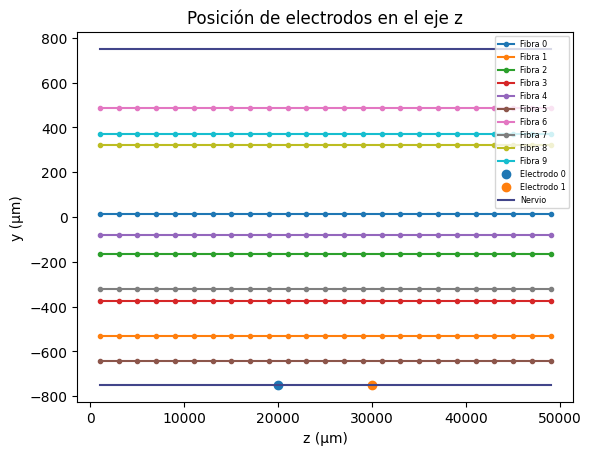

In [20]:
# 10. Ubicación de Electrodos respecto a los Nodos

a = Entorno(nombre='Experimento_01')
a.crear_nervio(semilla= 34,diametro = 1500,num_fibras=10,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 20000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 30000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]

fig = plt.figure() 

pos = a.nervio.informacion_fibras()[:,1]
#plt.plot(a.nervio.informacion_nodos[0],'r.')
for x,p in enumerate(pos):
    n = len(a.nervio.informacion_nodos[x])
    valor = p
    posy = np.full((n,), valor)
    plt.plot(a.nervio.informacion_nodos[x],posy,'.',linestyle='-',label = f'Fibra {x}')

for i,e in enumerate(a.electrodos):
    x,z = e.x,e.z
    plt.plot(z,y,'o',label = f"Electrodo {i}")

#Límites del nervio
plt.plot(a.nervio.informacion_nodos[0],np.full((len(a.nervio.informacion_nodos[0]),),a.nervio.limite_superior),color = '#42458A',label = 'Nervio')
plt.plot(a.nervio.informacion_nodos[0],np.full((len(a.nervio.informacion_nodos[0]),),a.nervio.limite_inferior),color = '#42458A')

plt.legend(fontsize = 'xx-small')
plt.title('Posición de electrodos en el eje z')
plt.xlabel('z (μm)')
plt.ylabel('y (μm)')
plt.show()
fig.savefig('1_10_electrodos_nodos.png',dpi=300, format="png")


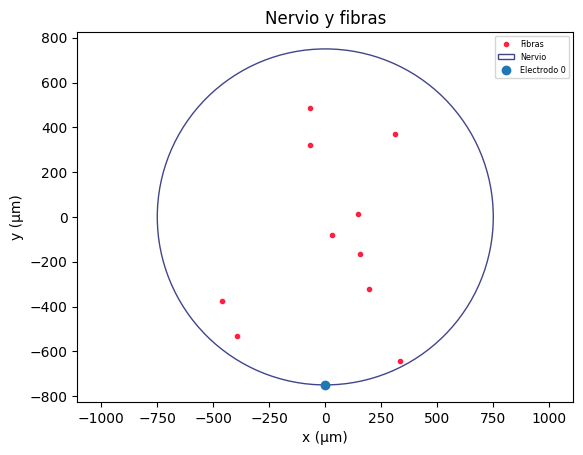

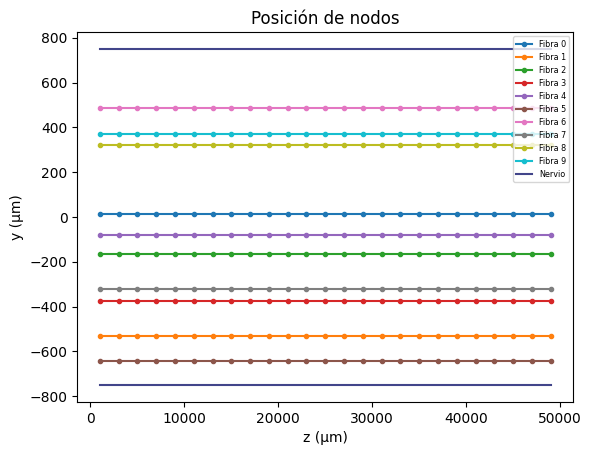

In [22]:
# 11. Nodos uniformes y la vista de las fibras

a = Entorno(nombre='Experimento_01')
a.crear_nervio(semilla=34,diametro = 1500,num_fibras=10,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 10000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
#a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 20000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
#a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 1000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
a.dibujar_entorno(color_fibras = '#FF1F40', borde_nervio='#42458A', titulo='Nervio y fibras',guardar=True,nombre_figura='08.nervio_nodos.png')
fig = plt.figure() 
pos = a.nervio.informacion_fibras()[:,1]
#plt.plot(a.nervio.informacion_nodos[0],'r.')
for x,p in enumerate(pos):
    n = len(a.nervio.informacion_nodos[x])
    valor = p
    posy = np.full((n,), valor)
    plt.plot(a.nervio.informacion_nodos[x],posy,'.',linestyle='-',label = f'Fibra {x}')

#Límites del nervio
plt.plot(a.nervio.informacion_nodos[0],np.full((len(a.nervio.informacion_nodos[0]),),a.nervio.limite_superior),color = '#42458A',label = 'Nervio')
plt.plot(a.nervio.informacion_nodos[0],np.full((len(a.nervio.informacion_nodos[0]),),a.nervio.limite_inferior),color = '#42458A')

plt.legend(fontsize = 'xx-small')
plt.title('Posición de nodos')
plt.xlabel('z (μm)')
plt.ylabel('y (μm)')
plt.show()
fig.savefig('1_11_nodosuniformes.png',dpi=300, format="png")


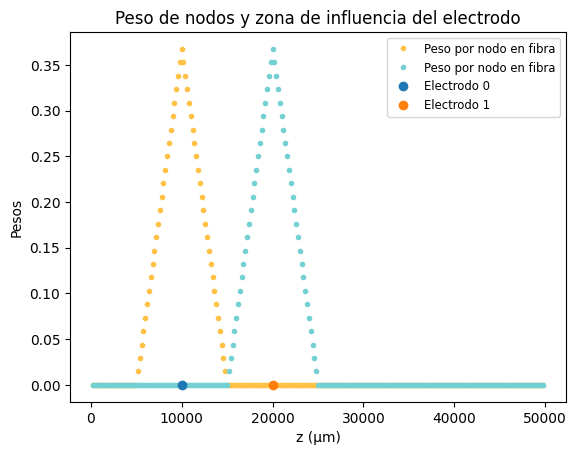

In [23]:
# 12. Zona de influencia del electrodo
a = Entorno(nombre='Experimento_01')
a.crear_nervio(diametro = 1500,num_fibras=10,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=200,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 10000,zona_influencia=5000,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 20000,zona_influencia=5000,grosor=0,funcion = funcion_trapecio)
#z = np.zeros_like(a.nervio.informacion_nodos[0])
#plt.plot(a.nervio.informacion_nodos[0],z,'c .')
fig = plt.figure() 
plt.plot(a.nervio.informacion_nodos[0],a.electrodos[0].pesos[0],'.',color = '#FFC247',label = 'Peso por nodo en fibra')
plt.plot(a.nervio.informacion_nodos[0],a.electrodos[1].pesos[0],'.',color = '#73D0D3',label = 'Peso por nodo en fibra')
for i,e in enumerate(a.electrodos):
    x,z = e.x,e.z
    plt.plot(z,0,'o',label = f"Electrodo {i}")
plt.legend(fontsize = 'small')
plt.title('Peso de nodos y zona de influencia del electrodo')
plt.xlabel('z (μm)')
plt.ylabel('Pesos')
plt.show()
fig.savefig('1_12_pesos_zonainfluencia.png',dpi=300, format="png")

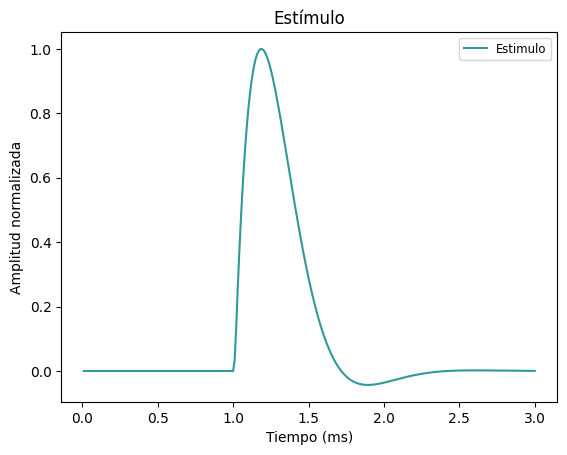

In [24]:
# 13. Estimulo, solo dibuja el primero porque asumimos que todos son iguales

a = Entorno(nombre='Experimento_01')
a.crear_nervio(diametro = 1500,num_fibras=10,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 10000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 20000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 1000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
#a.dibujar_entorno(color_fibras = '#FF1F40', borde_nervio='#42458A', titulo='Electrodos',guardar=True,nombre_figura='06.electrodos.png')
fig = plt.figure() 
plt.plot(a.estimulador.vector_tiempo*1000,a.estimulador.estimulo[0],color = '#31989B', label = 'Estimulo')
plt.ylabel('Amplitud normalizada')
plt.xlabel('Tiempo (ms)')
plt.title(f'Estímulo')
plt.legend(fontsize = 'small')
plt.show()
fig.savefig(f'1_13_estimulo.png',dpi=300, format="png")

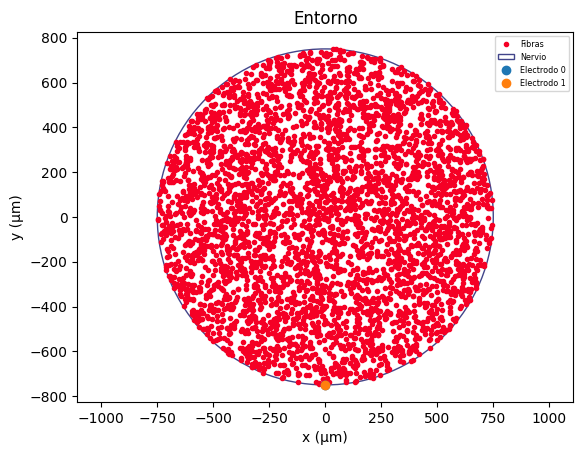

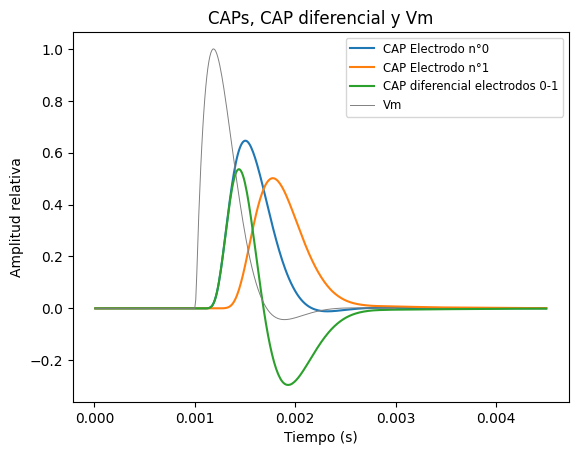

In [29]:
# 14. Entorno y gráficas
a = Entorno(nombre='Experimento_01')
a.crear_nervio(diametro = 1500,num_fibras=4000,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 10000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 20000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 1000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
a.cap()
a.cap_diferencial()
a.dibujar_entorno(borde_nervio='#42458A', color_fibras = '#F50025',guardar=True,nombre_figura='1_14a_entorno.png')
a.graficas(guardar=True,nombre_figura="1_14b_graficas.png",titulo="CAPs, CAP diferencial y Vm")

## <stan style = "color : orange "> 2. Nuevas implementaciones </stan>

In [ ]:
# 15. Grafica con variacion de diametros y sin superposicion

a = Entorno(nombre='Experimento_01')
a.crear_nervio(diametro = 1500,num_fibras=300,metodo_poblacion = 'uniforme_sin_superposicion',diametro_fibra=40,distancia_nodos=500,longitud=50000,porcentaje_cobertura=100,var_diametro=10.5,variacion_nodos = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 10000,zona_influencia=4000,grosor=1000,funcion = funcion_gaussiana)
#a.crear_electrodo(tipo='poligono',lista_coordenadas = [(-100,-750),(100,-750),(100,-800),(-100,-800)],pos_z = 20000,zona_influencia=4000,grosor=0,funcion = funcion_constante,valor = 1)
#a.crear_electrodo(tipo='circulo',pos_x = 100,pos_y = -800,pos_z = 20000,radio = 50,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 1000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
a.dibujar_entorno(forma_ploteo='fibras_con_diametro',borde_nervio='#42458A',borde_fibras = '#F50025',guardar=True,nombre_figura='12nervio_nuevo.png')
a.dibujar_entorno(borde_nervio='#42458A',color_fibras = '#F50025',guardar=True,nombre_figura='12nervio_nuevo_2.png')

# <stan style = "color : cyan "> Capítulo 5: Análisis comparativo </stan>

## <stan style = "color : orange "> Primera parte: nervio ciático del sapo </stan>

In [ ]:
# Generación de imágenes - GENERAL

a = Entorno(nombre='Experimento_01')
a.crear_nervio(diametro = 1524,num_fibras=4000,metodo_poblacion = 'desde_archivo',ubicacion_archivo = 'C:/Users/aguir/Desktop/Prroyecto/python/nervio_ciatico.csv',distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,variacion_nodos = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = 10000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = 20000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
a.cap()
a.cap_diferencial()
a.dibujar_entorno()
a.graficas(guardar=True,nombre_figura = 'p_general.png',titulo='CAPs y CAP diferencial')

In [ ]:
ubicaciones = ['C:/Users/aguir/Desktop/Prroyecto/python/nervio_ciatico_01.csv','C:/Users/aguir/Desktop/Prroyecto/python/nervio_ciatico_02.csv',
               'C:/Users/aguir/Desktop/Prroyecto/python/nervio_ciatico_03.csv','C:/Users/aguir/Desktop/Prroyecto/python/nervio_ciatico_04.csv',
               'C:/Users/aguir/Desktop/Prroyecto/python/nervio_ciatico_05.csv','C:/Users/aguir/Desktop/Prroyecto/python/nervio_ciatico_06.csv',
               'C:/Users/aguir/Desktop/Prroyecto/python/nervio_ciatico_07.csv','C:/Users/aguir/Desktop/Prroyecto/python/nervio_ciatico_08.csv',
               'C:/Users/aguir/Desktop/Prroyecto/python/nervio_ciatico_09.csv','C:/Users/aguir/Desktop/Prroyecto/python/nervio_ciatico_10.csv']

In [ ]:
# Imagen 1 - Todas las señales CAPs, CAP diferencial y Vm

fig = plt.figure()
i = 0
for ubicacion in ubicaciones:
    a = Entorno(nombre='Experimento_01')
    a.crear_nervio(diametro = 1524,num_fibras=4000,metodo_poblacion = 'desde_archivo',ubicacion_archivo = ubicacion,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,variacion_nodos = 0)
    a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = 10000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
    a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = 20000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
    a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
    #plt.plot(a.estimulador.vector_tiempo*1000,a.estimulador.estimulo[0], label = f'fc = {f}Hz')
    a.cap()
    a.cap_diferencial()
    t = np.arange(1/a.frec_muestreo,1/a.frec_muestreo+a.tiempo_registro,1/a.frec_muestreo)
        
    #CAP
    plt.plot(t,a.electrodos[0].cap,label = f"CAP Electrodo n°{0}" if i==0 else '',color = '#FF0A2F',linewidth = 0.7)
    plt.plot(t,a.electrodos[1].cap,label = f"CAP Electrodo n°{1}"if i==0 else '',color = '#42458A',linewidth = 0.7)
    #CAP diferencial
    plt.plot(t,a.cap_dif, label = f"CAP diferencial electrodos {a.capdif_pos1}-{a.capdif_pos2}"if i==0 else '',color = '#8EA604',linewidth = 0.7)
    #Vm  
    plt.plot(a.estimulador.vector_tiempo,a.estimulador.estimulo[0], label = "Vm"if i==0 else '', color = 'gray',linewidth = 0.3)
    
    i+=1

plt.title('Estimulo, CAPs y CAP diferencial')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud relativa')
plt.legend(fontsize = 'small')
#plt.show()

fig.savefig('p_01.png',dpi=300, format="png")  


In [ ]:
# Imagen 2 - Variación distancias entre electrodos

posicion_electrodo2 = [20000,30000,40000,50000,60000,70000]
colores = ['#912F40','#0A58FF','#63934D','#C16200','#B821C0','#5259A3']

fig = plt.figure()

for idx,pos in enumerate(posicion_electrodo2):
    for i,ubicacion in enumerate(ubicaciones):
        a = Entorno(nombre='Experimento_01')
        a.crear_nervio(diametro = 1524,num_fibras=4000,metodo_poblacion = 'desde_archivo',ubicacion_archivo = ubicacion,distancia_nodos=2000,longitud=100000,porcentaje_cobertura=100,variacion_nodos = 0)
        a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = 10000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
        a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = pos,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
        a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
        #plt.plot(a.estimulador.vector_tiempo*1000,a.estimulador.estimulo[0], label = f'fc = {f}Hz')
        a.cap()
        a.cap_diferencial()
        t = np.arange(1/a.frec_muestreo,1/a.frec_muestreo+a.tiempo_registro,1/a.frec_muestreo)
            
        #CAP
        # plt.plot(t,a.electrodos[0].cap,label = f"CAP Electrodo n°{0}" if i==0 else '',color = '#FF0A2F',linewidth = 0.7)
        # plt.plot(t,a.electrodos[1].cap,label = f"CAP Electrodo n°{1}"if i==0 else '',color = '#42458A',linewidth = 0.7)
        
        #CAP diferencial
        plt.plot(t,a.cap_dif, label = f"CAP dif con |de1-de2| = {pos/10000 - 1} cm"if i==0 else '',color = colores[idx],linewidth = 0.7)
        #Vm  
        #plt.plot(a.estimulador.vector_tiempo,a.estimulador.estimulo[0], label = "Vm"if i==0 else '', color = 'gray',linewidth = 0.3)
    

plt.title('Variación de distancia entre electrodos')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud relativa')
plt.legend(fontsize = 'small')
#plt.show()

fig.savefig('p_02.png',dpi=300, format="png")  

In [ ]:
# Imagen 3 - Manteniendo distancia interelectrodo, variar posicion del conjunto

posicion_electrodo1 = [10000,20000,30000,40000,50000,60000]
posicion_electrodo2 = [20000,30000,40000,50000,60000,70000]

colores = ['#912F40','#0A58FF','#63934D','#C16200','#B821C0','#5259A3']

fig = plt.figure()

for idx,pos in enumerate(posicion_electrodo2): #bucle que varía
    for i,ubicacion in enumerate(ubicaciones): #repeticiones
        a = Entorno(nombre='Experimento_01')
        a.crear_nervio(diametro = 1524,num_fibras=4000,metodo_poblacion = 'desde_archivo',ubicacion_archivo = ubicacion,distancia_nodos=2000,longitud=100000,porcentaje_cobertura=100,variacion_nodos = 0)
        a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = posicion_electrodo1[idx],zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
        a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = pos,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
        a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
        #plt.plot(a.estimulador.vector_tiempo*1000,a.estimulador.estimulo[0], label = f'fc = {f}Hz')
        a.cap()
        a.cap_diferencial()
        t = np.arange(1/a.frec_muestreo,1/a.frec_muestreo+a.tiempo_registro,1/a.frec_muestreo)
            
        #CAP
        # plt.plot(t,a.electrodos[0].cap,label = f"CAP Electrodo n°{0}" if i==0 else '',color = '#FF0A2F',linewidth = 0.7)
        # plt.plot(t,a.electrodos[1].cap,label = f"CAP Electrodo n°{1}"if i==0 else '',color = '#42458A',linewidth = 0.7)
        
        #CAP diferencial
        plt.plot(t,a.cap_dif, label = f"CAP dif de1={posicion_electrodo1[idx]/10000}cm y de2={pos/10000}cm"if i==0 else '',color = colores[idx],linewidth = 0.7)
        #Vm  
        #plt.plot(a.estimulador.vector_tiempo,a.estimulador.estimulo[0], label = "Vm"if i==0 else '', color = 'gray',linewidth = 0.3)
    

plt.title('Variación de posición de electrodos en conjunto')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud relativa')
plt.legend(fontsize = 'small')
#plt.show()

fig.savefig('p_03.png',dpi=300, format="png") 

In [ ]:
# Imagen 4 - Variación en la cantidad de nodos 

zonas = [2000,6000,10000]
colores = ['#912F40','#0A58FF','#63934D','#C16200','#B821C0','#5259A3']

fig = plt.figure()

for idx,z in enumerate(zonas):
    for i,ubicacion in enumerate(ubicaciones):
        a = Entorno(nombre='Experimento_01')
        a.crear_nervio(diametro = 1524,num_fibras=4000,metodo_poblacion = 'desde_archivo',ubicacion_archivo = ubicacion,distancia_nodos=2000,longitud=100000,porcentaje_cobertura=100,variacion_nodos = 0)
        a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = 20000,zona_influencia=z,grosor=0,funcion = funcion_trapecio)
        a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = 30000,zona_influencia=z,grosor=0,funcion = funcion_trapecio)
        a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
        #plt.plot(a.estimulador.vector_tiempo*1000,a.estimulador.estimulo[0], label = f'fc = {f}Hz')
        a.cap()
        a.cap_diferencial()
        t = np.arange(1/a.frec_muestreo,1/a.frec_muestreo+a.tiempo_registro,1/a.frec_muestreo)
            
        #CAP
        # plt.plot(t,a.electrodos[0].cap,label = f"CAP Electrodo n°{0}" if i==0 else '',color = '#FF0A2F',linewidth = 0.7)
        # plt.plot(t,a.electrodos[1].cap,label = f"CAP Electrodo n°{1}"if i==0 else '',color = '#42458A',linewidth = 0.7)
        
        #CAP diferencial
        plt.plot(t,a.cap_dif, label = f"CAPdif con zona de influencia = {z}μm"if i==0 else '',color = colores[idx],linewidth = 0.7)
        #Vm  
        #plt.plot(a.estimulador.vector_tiempo,a.estimulador.estimulo[0], label = "Vm"if i==0 else '', color = 'gray',linewidth = 0.3)
    

plt.title('Variaciónen de zona de influencia de electrodos')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud relativa')
plt.legend(fontsize = 'small')
#plt.show()

fig.savefig('p_04.png',dpi=300, format="png")

In [ ]:
# Imagen 5 - Intento de variar la duración de Vm -- Potencial de acción

frecuencias = [1200,2300,3200,4000]
tiempos = [1.2,0.6,0.4,0.3]
colores = ['#912F40','#0A58FF','#63934D','#C16200','#B821C0','#5259A3']

fig = plt.figure()

for idx,f in enumerate(frecuencias):
    for i,ubicacion in enumerate(ubicaciones):
        a = Entorno(nombre='Experimento_01')
        a.crear_nervio(diametro = 1524,num_fibras=4000,metodo_poblacion = 'desde_archivo',ubicacion_archivo = ubicacion,distancia_nodos=2000,longitud=100000,porcentaje_cobertura=100,variacion_nodos = 0)
        a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = 10000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
        a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = 20000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
        a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = f,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
        #plt.plot(a.estimulador.vector_tiempo*1000,a.estimulador.estimulo[0], label = f'fc = {f}Hz')
        a.cap()
        a.cap_diferencial()
        t = np.arange(1/a.frec_muestreo,1/a.frec_muestreo+a.tiempo_registro,1/a.frec_muestreo)
            
        #CAP
        # plt.plot(t,a.electrodos[0].cap,label = f"CAP Electrodo n°{0}" if i==0 else '',color = '#FF0A2F',linewidth = 0.7)
        # plt.plot(t,a.electrodos[1].cap,label = f"CAP Electrodo n°{1}"if i==0 else '',color = '#42458A',linewidth = 0.7)
        
        #CAP diferencial
        plt.plot(t,a.cap_dif, label = f"CAPdif - Vm con {tiempos[idx]}ms de duración"if i==0 else '',color = colores[idx],linewidth = 0.7)
        #Vm  
        #plt.plot(a.estimulador.vector_tiempo,a.estimulador.estimulo[0], label = "Vm"if i==0 else '', color = 'gray',linewidth = 0.3)
    

plt.title('Variaciónen duración de Vm')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Amplitud relativa')
plt.legend(fontsize = 'small')
#plt.show()

fig.savefig('p_05.png',dpi=300, format="png")


In [ ]:
# Imagen 5 - Solo Vm
#frecuencias = [800,1600,2300,3000]
frecuencias = [1200,2300,3200,4000]
tiempos = [1.2,0.6,0.4,0.3]
colores = ['#912F40','#0A58FF','#63934D','#C16200','#B821C0','#5259A3']

fig = plt.figure()

for idx,f in enumerate(frecuencias):
    a = Entorno(nombre='Experimento_01',tiempo_registro=0.003)
    a.crear_nervio(diametro = 1524,num_fibras=4000,metodo_poblacion = 'desde_archivo',ubicacion_archivo = ubicaciones[1],distancia_nodos=2000,longitud=100000,porcentaje_cobertura=100,variacion_nodos = 0)
    a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = 10000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
    a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = 20000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
    a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.002,tiempo_inicio = 0,frec_corte = f,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
        #plt.plot(a.estimulador.vector_tiempo*1000,a.estimulador.estimulo[0], label = f'fc = {f}Hz')
        # a.cap()
        # a.cap_diferencial()
    t = np.arange(1/a.frec_muestreo,1/a.frec_muestreo+a.tiempo_registro,1/a.frec_muestreo)
            
        #CAP
        # plt.plot(t,a.electrodos[0].cap,label = f"CAP Electrodo n°{0}" if i==0 else '',color = '#FF0A2F',linewidth = 0.7)
        # plt.plot(t,a.electrodos[1].cap,label = f"CAP Electrodo n°{1}"if i==0 else '',color = '#42458A',linewidth = 0.7)
        
        #CAP diferencial
        #plt.plot(t,a.cap_dif, label = f"CAPdif fcorte de Vm={f}Hz"if i==0 else '',color = colores[idx],linewidth = 0.7)
        #Vm  
    plt.plot(a.estimulador.vector_tiempo/1000,a.estimulador.estimulo[0], label = f"Vm con {tiempos[idx]}ms de duración", color = colores[idx])

plt.title('Variaciónen duración de Vm')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Amplitud relativa')
plt.legend(fontsize = 'small')
#plt.show()

fig.savefig('p_05_1.png',dpi=300, format="png")


In [ ]:
# Imagen 6 - Variación de la conductividad transversal o porcentaje de cobertura (Wmax)

porcentajes = [25,50,75,100]
colores = ['#912F40','#0A58FF','#63934D','#C16200','#B821C0','#5259A3']

fig = plt.figure()

for idx,p in enumerate(porcentajes):
    for i,ubicacion in enumerate(ubicaciones):
        a = Entorno(nombre='Experimento_01')
        a.crear_nervio(diametro = 1524,num_fibras=4000,metodo_poblacion = 'desde_archivo',ubicacion_archivo = ubicacion,distancia_nodos=2000,longitud=100000,porcentaje_cobertura=p,variacion_nodos = 0)
        a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = 10000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
        a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = 20000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
        a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
        #plt.plot(a.estimulador.vector_tiempo*1000,a.estimulador.estimulo[0], label = f'fc = {f}Hz')
        a.cap()
        a.cap_diferencial()
        t = np.arange(1/a.frec_muestreo,1/a.frec_muestreo+a.tiempo_registro,1/a.frec_muestreo)
            
        #CAP
        # plt.plot(t,a.electrodos[0].cap,label = f"CAP Electrodo n°{0}" if i==0 else '',color = '#FF0A2F',linewidth = 0.7)
        # plt.plot(t,a.electrodos[1].cap,label = f"CAP Electrodo n°{1}"if i==0 else '',color = '#42458A',linewidth = 0.7)
        
        #CAP diferencial
        plt.plot(t,a.cap_dif, label = f"CAPdif porcentaje de cobertura={p}%"if i==0 else '',color = colores[idx],linewidth = 0.7)
        #Vm  
        #plt.plot(a.estimulador.vector_tiempo,a.estimulador.estimulo[0], label = "Vm"if i==0 else '', color = 'gray',linewidth = 0.3)
    

plt.title('Variación del porcentaje de cobertura de los electrodos')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud relativa')
plt.legend(fontsize = 'small')
#plt.show()

fig.savefig('p_06.png',dpi=300, format="png")



## <stan style = "color : orange "> Segunda parte: nervio ciático rana  </stan>

In [ ]:
# Exactamente lo del paper - Figura 3a

voltajes = [0.15,0.4,0.6,0.67,0.73,0.78]
colores = ['#912F40','#0A58FF','#63934D','#C16200','#B821C0','#5259A3']
colores = ['#FFC933','#E3A327','#D59021','#C67C1A','#AA550E','#8D2E01']
colores = ['#FFC933','#F1A837','#E3863B','#CD6327','#B63F12','#9D1107','#791D16']

fig = plt.figure()
maximos = []

for i,v in enumerate(voltajes):
    a = Entorno(nombre='Experimento_01', tiempo_registro=0.002)
    a.crear_nervio(diametro = 1300,num_fibras=2700,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=16,var_diametro=6,distancia_nodos=2000,longitud=80000,porcentaje_cobertura=100,variacion_nodos = 500,semilla = 245)
    # a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -650,pos_z = 20000,zona_influencia=10000,grosor=2000,funcion = funcion_trapecio)
    # a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -650,pos_z = 40000,zona_influencia=10000,grosor=2000,funcion = funcion_trapecio)
    a.crear_electrodo(tipo = 'poligono',lista_coordenadas = [(-1000,-650),(1000,650),(-1000,-1650),(1000,-1650)],pos_z = 20000,zona_influencia=10000,funcion=funcion_trapecio)
    a.crear_electrodo(tipo = 'poligono',lista_coordenadas = [(-1000,-650),(1000,650),(-1000,-1650),(1000,-1650)],pos_z = 40000,zona_influencia=10000,funcion=funcion_trapecio)
    a.crear_estimulo(tipo_estimulo='cuadrado',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.0003,duracion = 0.0002,voltaje = v/1000*2700) #lista_inicio = [0,0.001,0.002]
    a.cap()
    a.cap_diferencial()
    t = np.arange(1/a.frec_muestreo,1/a.frec_muestreo+a.tiempo_registro,1/a.frec_muestreo)
        
    #CAP
    #plt.plot(t,a.electrodos[0].cap,label = f"CAP Electrodo n°{0}, {v}V",color = colores[i],linewidth = 0.7)
    # plt.plot(t,a.electrodos[1].cap,label = f"CAP Electrodo n°{1}"if i==0 else '',color = '#42458A',linewidth = 0.7)
    #CAP diferencial
    plt.plot(t/1000,a.cap_dif, label = f"CAP diferencial voltaje = {round(v*2700/1000,1)}V",color = colores[i],linewidth = 1.3)
    maximos.append(max(a.cap_dif))
    #Vm  
    #plt.plot(a.estimulador.vector_tiempo,a.estimulador.estimulo[0], label = "Vm"if i==0 else '', color = 'gray',linewidth = 0.5)

plt.title('Variación de voltaje del estimulador')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Amplitud [mv]')
plt.legend(fontsize = 'small')
#plt.show()

fig.savefig('rana_voltajes.png',dpi=300, format="png")
    

In [ ]:
# Exactamente lo del paper - Figura 3b


fig = plt.figure()
plt.plot(voltajes,maximos,"o-",color = '#CD6327')
plt.title('Máxima amplitud de CAP dif vs Voltaje aplicado')
plt.xlabel('Voltaje [V]')
plt.ylabel('Amplitud [mV]')
#plt.legend(fontsize = 'small')
#plt.show()

fig.savefig('rana_voltajes_vs_amplitud.png',dpi=300, format="png")